<a href="https://colab.research.google.com/github/Shreenidhi-Kovai-Sivabalan/Fake-News-Detection/blob/main/MainCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing Coursework

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets
from datasets import load_dataset
import pandas as pd

In [ ]:
# Loading the dataset
data = load_dataset('ErfanMoosaviMonazzah/fake-news-detection-dataset-English')

# Splitting the dataset as training set, validation set and test set
data_train = pd.DataFrame(data['train'])
data_val = pd.DataFrame(data['validation'])
data_test = pd.DataFrame(data['test'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.tsv:  80%|########  | 62.9M/78.4M [00:00<?, ?B/s]

validation.tsv:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8267 [00:00<?, ? examples/s]

In [ ]:
# Size of each set
print(f'Train data shape: {data_train.shape}')
print(f'Validation data shape: {data_val.shape}')
print(f'Test data shape: {data_test.shape}')

Train data shape: (30000, 6)
Validation data shape: (6000, 6)
Test data shape: (8267, 6)


In [ ]:
print(f"Train size: {len(data_train)}")
print(f"Validation size: {len(data_val)}")
print(f"Test size: {len(data_test)}")

Train size: 30000
Validation size: 6000
Test size: 8267


In [ ]:
data_train.head()

,Unnamed: 0,title,text,subject,date,label
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0


Exploratory Data Analysis (EDA)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Checking missing values
print(f"Missing values in train data:\n{data_train.isnull().sum()}")

Missing values in train data:
Unnamed: 0    0
title         0
text          0
subject       0
date          0
label         0
dtype: int64


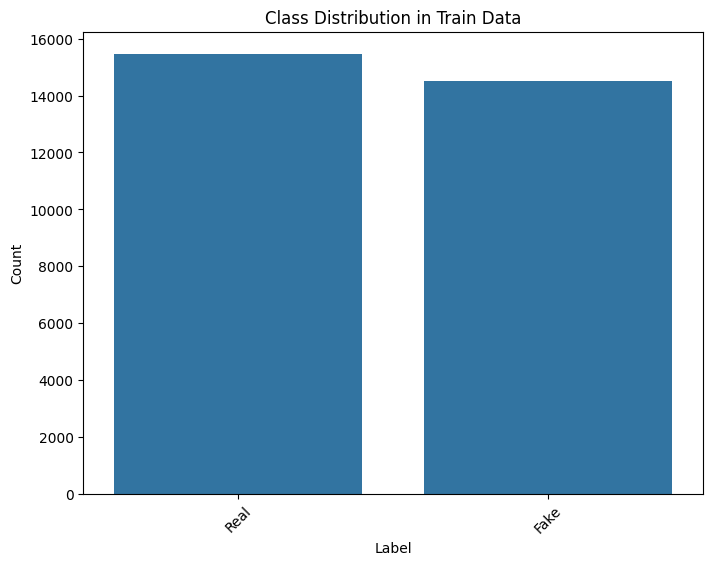

In [ ]:
# Class Distribution in Train Data
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data_train)
plt.title('Class Distribution in Train Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Real', 'Fake'], rotation=45)
plt.show()

In [ ]:
class_counts = data_train['label'].value_counts()
class_counts

# The dataset is not imbalanced so class balancing techniques like
# SMOTE, BorderlineSMOTE, ADASYN don't have to applied.

,count
label,
0,15478
1,14522


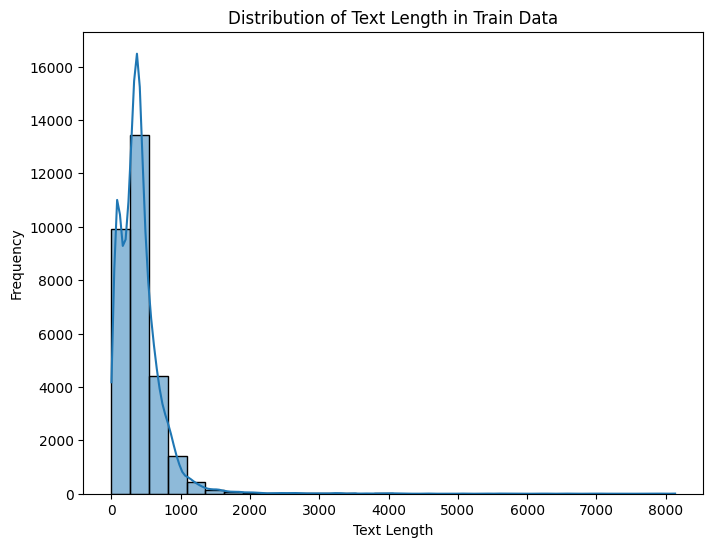

In [ ]:
# Analyse test length - number of words
data_train['text_length'] = data_train['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,6))
sns.histplot(data_train['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Length in Train Data')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Sample text for real and fake news articles
print('Sample real news article:\n')
print(data_train[data_train['label'] == 0]['text'].iloc[0])
print('\nSample fake news article:\n')
print(data_train[data_train['label'] == 1]['text'].iloc[0])

Sample real news article:

How did this man come to OWN this store? There is no information on much about this fraudster except that he stole from Americans and is getting just a slap on the wrist. It s no wonder these people are repeat offenders!A hispanic store owner testified in court through a Spanish translator (Why no English?) that he swindled the American tax payers out of millions via food stamp fraud. Eduardo Leonardo plead guilty to stealing from the USDA by illegally exchanging over a million dollars of food stamp benefits for cash for over two years. I stole from the USDA and the Food and Nutrition Service,  Eduardo Leonardo said slowly in Spanish through a translator in Brooklyn Federal Court.  It was an exchange of benefits for cash. Leonardo, 57,  admitted to committing  food stamp  fraud between Oct. 2015 and March 2017 by giving customers cash in exchange for running their EBT cards for a higher amount, which the federal government would later reimburse.In one instanc

Preprocessing

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocessing_text(text):
  text = text.lower() # converting the text into lower case
  text = re.sub(r'[^a-z\s]', '', text) # removing unwanted characters - punctuation, numbers, speacial characters
  tokens = word_tokenize(text) # tokenisation
  filtered_tokens = [token for token in tokens if token not in stop_words] # removing stop words
  cleaned_text = ' '.join(filtered_tokens)
  return cleaned_text

In [ ]:
# Applying the preprocessing steps to the dataset
data_train['cleaned_text'] = data_train['text'].apply(preprocessing_text)
data_val['cleaned_text'] = data_val['text'].apply(preprocessing_text)
data_test['cleaned_text'] = data_test['text'].apply(preprocessing_text)

In [ ]:
# Sample of Preprocessed Real News Article
print('Sample preprocessed real news article:\n')
data_train[data_train['label'] == 0].iloc[0]['cleaned_text']

Sample preprocessed real news article:



'man come store information much fraudster except stole americans getting slap wrist wonder people repeat offendersa hispanic store owner testified court spanish translator english swindled american tax payers millions via food stamp fraud eduardo leonardo plead guilty stealing usda illegally exchanging million dollars food stamp benefits cash two years stole usda food nutrition service eduardo leonardo said slowly spanish translator brooklyn federal court exchange benefits cash leonardo admitted committing food stamp fraud oct march giving customers cash exchange running ebt cards higher amount federal government would later reimbursein one instance undercover witness usda went super economic picked jar peanut butter jelly crackers totaling witness asked leonardo exchange benefits cash leonardo charged undercover ebt card gave witness cash making profitthe usda lost total transactionsthe scammer run store super economic one way supermarket glenwood road canarsie since dec became regis

In [ ]:
# Sample of Preprocessed Fake News Article
print('\nSample preprocessed fake news article:\n')
data_train[data_train['label'] == 1].iloc[0]['cleaned_text']


Sample preprocessed fake news article:



'former cia director john brennan friday criticized disgraceful president donald trumps efforts play us intelligence agencies assessment russia meddled us election trumps administration dogged investigations allegations russian interference last years us presidential election possible ties campaign team speaking one day first meeting russian president vladimir putin hamburg earlier month trump said suspected russian interference election one knows sure types comments disgraceful person said ashamed said brennan cia chief former president barack obama aspen security forum special counsel robert mueller several us congressional committees investigating whether russia interfered election colluded trumps campaign try swing race favor democratic rival hillary clinton probes focused almost exclusively moscows actions lawmakers intelligence officials said evidence surfaced publicly implicating countries moscow denied interference trump said campaign collude russia brennan said disappointed pr

In [ ]:
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.util import ngrams

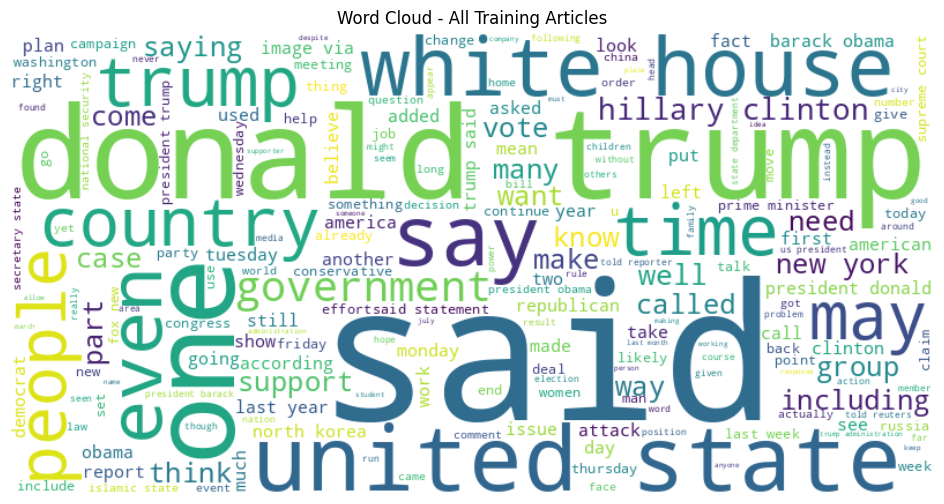

In [ ]:
# Visualising the word cloud
all_words = ' '.join(data_train['cleaned_text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - All Training Articles")
plt.show()

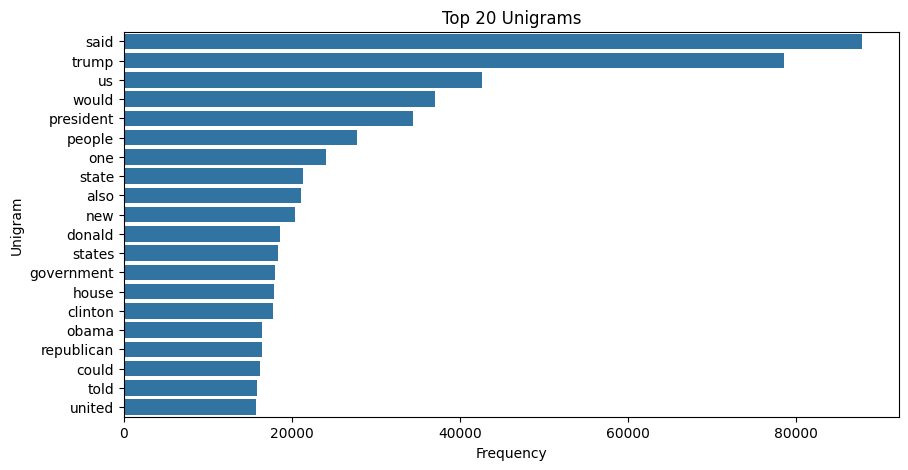

In [ ]:
# Frequently occurring words
tokens = nltk.word_tokenize(all_words)
unigram_freq = Counter(tokens)
common_unigrams = unigram_freq.most_common(20)
unigrams_df = pd.DataFrame(common_unigrams, columns=['Unigram', 'Frequency'])

plt.figure(figsize=(10,5))
sns.barplot(x='Frequency', y='Unigram', data=unigrams_df)
plt.title("Top 20 Unigrams")
plt.show()

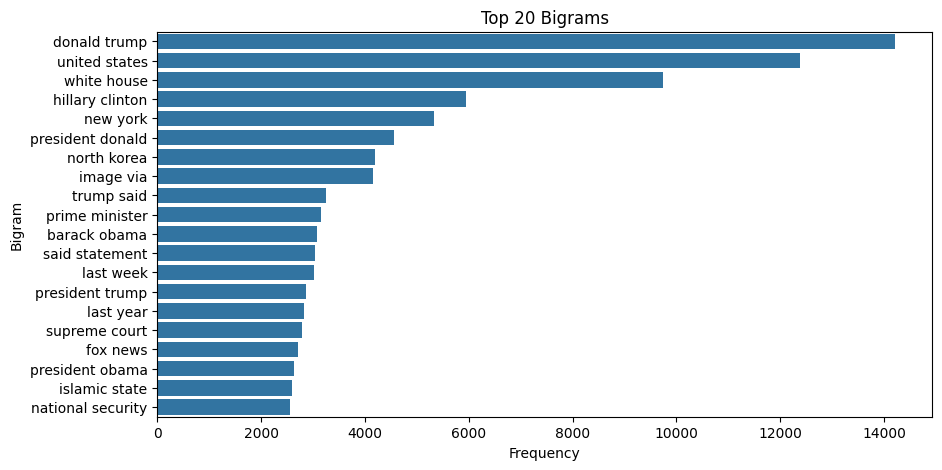

In [ ]:
# Frequently occurring bigrams
bigram_freq = Counter(ngrams(tokens, 2))
common_bigrams = bigram_freq.most_common(20)
bigrams_df = pd.DataFrame(common_bigrams, columns=['Bigram', 'Frequency'])
bigrams_df['Bigram'] = bigrams_df['Bigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(10,5))
sns.barplot(x='Frequency', y='Bigram', data=bigrams_df)
plt.title("Top 20 Bigrams")
plt.show()

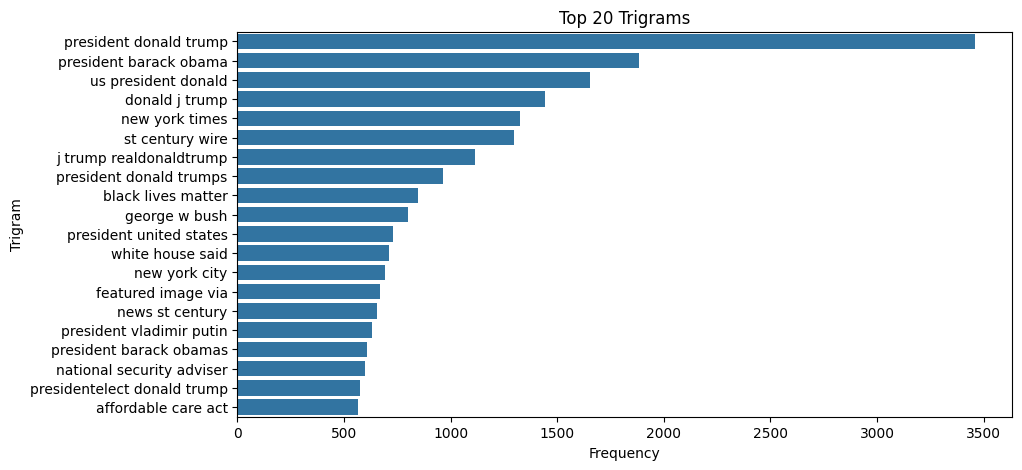

In [ ]:
# Frequently occurring trigrams
trigram_freq = Counter(ngrams(tokens, 3))
common_trigrams = trigram_freq.most_common(20)
trigrams_df = pd.DataFrame(common_trigrams, columns=['Trigram', 'Frequency'])
trigrams_df['Trigram'] = trigrams_df['Trigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(10,5))
sns.barplot(x='Frequency', y='Trigram', data=trigrams_df)
plt.title("Top 20 Trigrams")
plt.show()

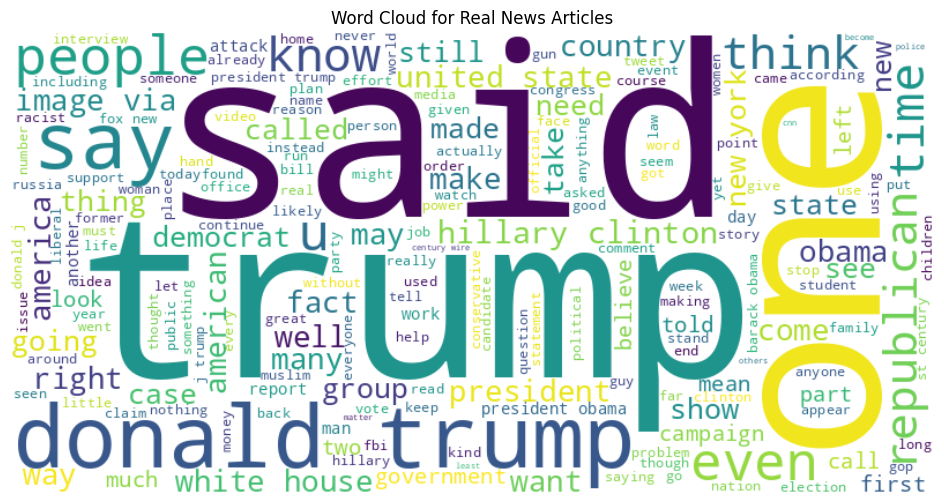

In [ ]:
# Word Cloud for Real News
real_news_text = ' '.join(data_train[data_train['label'] == 0]['cleaned_text'])

real_news_wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(real_news_text)
plt.figure(figsize = (12, 6))
plt.imshow(real_news_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud for Real News Articles')
plt.show()

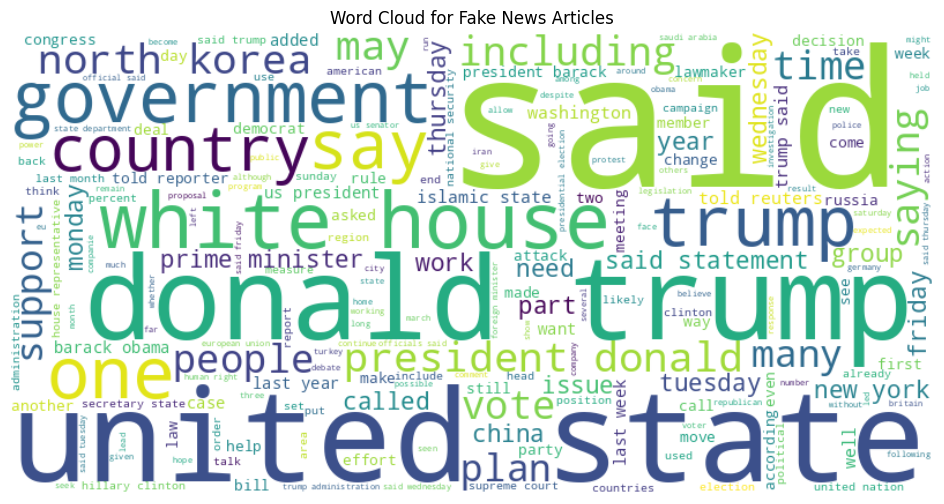

In [ ]:
# Word Cloud for Fake News
fake_news_text = ' '.join(data_train[data_train['label'] == 1]['cleaned_text'])

fake_news_wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(fake_news_text)
plt.figure(figsize = (12, 6))
plt.imshow(fake_news_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News Articles')
plt.show()

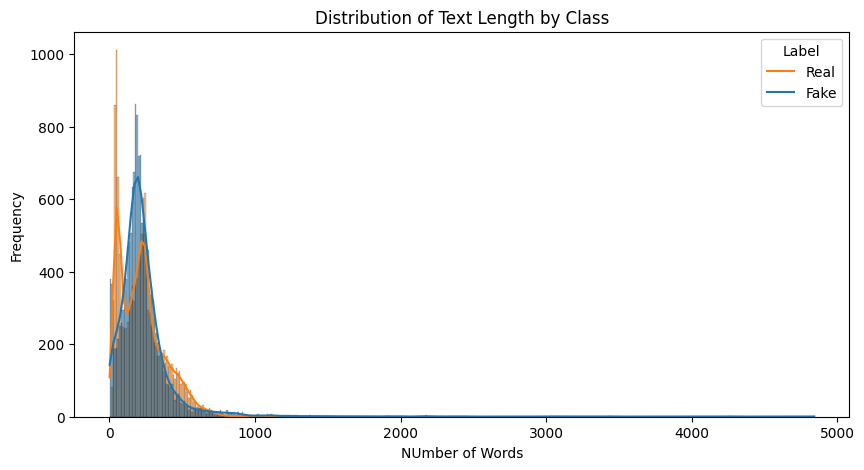

In [ ]:
# Text length distributions by class
data_train['text_length'] = data_train['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize = (10, 5))
sns.histplot(data = data_train, x = 'text_length', hue = 'label', kde = True)
plt.title('Distribution of Text Length by Class')
plt.xlabel('NUmber of Words')
plt.ylabel('Frequency')
plt.legend(title = 'Label', labels = ['Real', 'Fake'])
plt.show()

TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorisation
tfidf = TfidfVectorizer(max_features=5000)

In [ ]:
X_train_tfidf = tfidf.fit_transform(data_train['cleaned_text'])
X_val_tfidf = tfidf.transform(data_val['cleaned_text'])
X_test_tfidf = tfidf.transform(data_test['cleaned_text'])

In [ ]:
y_train = data_train['label']
y_val = data_val['label']
y_test = data_test['label']

Logistic Regression (for baseline) on TF-IDF

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Training Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Predicting on Validation set
y_pred_val_tfidf = log_reg.predict(X_val_tfidf)

In [ ]:
# Evaluation
print('Validation Data Evaluation (Logistic Regression):\n')
print(f'Accuracy: {accuracy_score(y_val, y_pred_val_tfidf)}')
print('\nClassification Report:\n')
print(classification_report(y_val, y_pred_val_tfidf))

Validation Data Evaluation (Logistic Regression):

Accuracy: 0.9818333333333333

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3089
           1       0.98      0.98      0.98      2911

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



In [ ]:
# Confusion Matrix
cmat = confusion_matrix(y_val, y_pred_val_tfidf)
cmat

array([[3024,   65],
       [  44, 2867]])

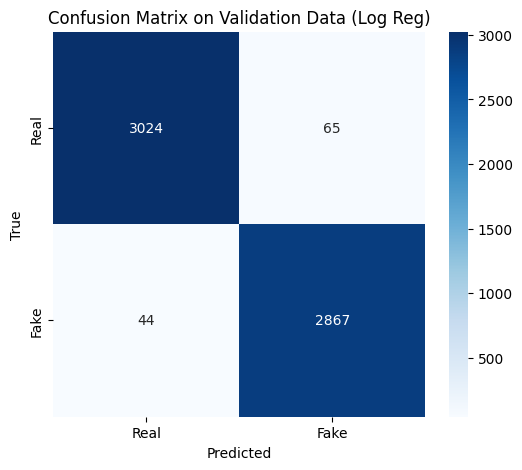

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cmat, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Validation Data (Log Reg)')
plt.show()

Adding Bigrams and Trigrams in TF-IDF

In [ ]:
# TF-IDF with Bigrams and Trigrams
tfidf_ngram = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
# ngram_range=(1,3) means unigrams, bigrams and trigrams

X_train_ngram = tfidf_ngram.fit_transform(data_train['cleaned_text'])
X_val_ngram = tfidf_ngram.transform(data_val['cleaned_text'])
X_test_ngram = tfidf_ngram.transform(data_test['cleaned_text'])

Logistic Regression on TF-IDF with Bigram and Trigram

In [ ]:
# Training Logistic Regression on TF-IDF N-grams data
log_reg.fit(X_train_ngram, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Predicting on Validation Set
y_pred_val_ngram = log_reg.predict(X_val_ngram)

In [ ]:
# Evaluate the model
print('Validation Data Evaluation (Log Reg with Bigrams/Trigrams):\n')
print(f'Accuracy: {accuracy_score(y_val, y_pred_val_ngram)}')
print('\nClassification Report:\n')
print(classification_report(y_val, y_pred_val_ngram))

Validation Data Evaluation (Log Reg with Bigrams/Trigrams):

Accuracy: 0.9863333333333333

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3089
           1       0.98      0.99      0.99      2911

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



In [ ]:
# Confusion Matrix
cmat_ngram = confusion_matrix(y_val, y_pred_val_ngram)
cmat_ngram

array([[3042,   47],
       [  35, 2876]])

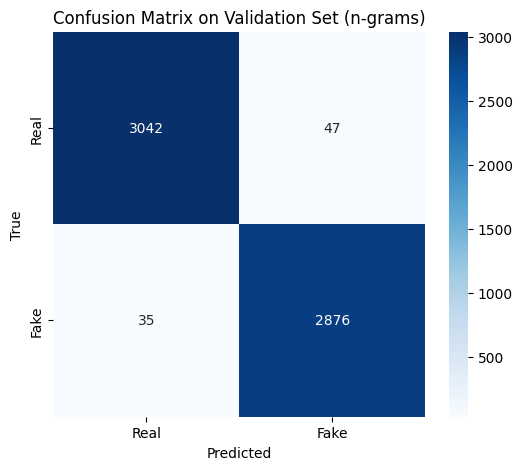

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cmat_ngram, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Validation Set (n-grams)')
plt.show()

In [ ]:
# Running on test data

y_test_pred_ngram = log_reg.predict(X_test_ngram)

print('Test Set Evaluation (Log Reg w/ n-grams):\n')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_ngram)}')
print("\nTest Set Performance (with Bigrams/Trigrams):")
print(classification_report(y_test, y_test_pred_ngram))
print()

Test Set Evaluation (Log Reg w/ n-grams):

Accuracy: 0.9858473448651264

Test Set Performance (with Bigrams/Trigrams):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4284
           1       0.98      0.99      0.99      3983

    accuracy                           0.99      8267
   macro avg       0.99      0.99      0.99      8267
weighted avg       0.99      0.99      0.99      8267




In [ ]:
#Confusion Matrix for test data
cmat_test = confusion_matrix(y_test, y_test_pred_ngram)
cmat_test

array([[4219,   65],
       [  52, 3931]])

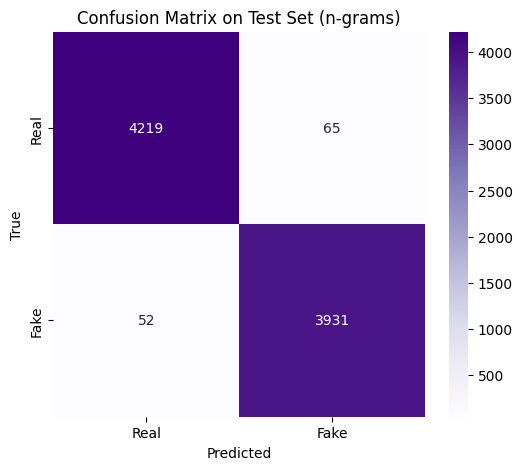

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cmat_test, annot=True, fmt='d', cmap='Purples', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set (n-grams)')
plt.show()

SVM

In [ ]:
from sklearn.svm import LinearSVC

# Training SVM model
svm_model = LinearSVC()
svm_model.fit(X_train_ngram, y_train)

LinearSVC()

In [ ]:
# Predicting on val set
y_pred_val_svm = svm_model.predict(X_val_ngram)

In [ ]:
print('Validation Data Evaluation (SVM):\n')
print(f'Accuracy: {accuracy_score(y_val, y_pred_val_svm)}')
print('\nClassification Report:\n')
print(classification_report(y_val, y_pred_val_svm))

Validation Data Evaluation (SVM):

Accuracy: 0.9911666666666666

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3089
           1       0.99      0.99      0.99      2911

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



In [ ]:
# Confusion matrix for validation set
cmat_svm = confusion_matrix(y_val, y_pred_val_svm)
cmat_svm

array([[3067,   22],
       [  31, 2880]])

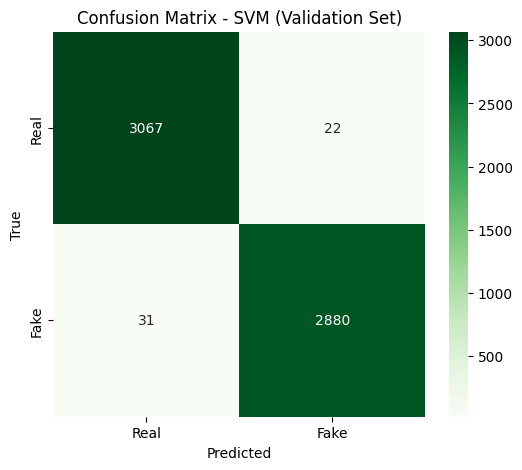

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cmat_svm, annot=True, fmt='d', cmap='Greens', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM (Validation Set)')
plt.show()

In [ ]:
# Predicting on test set
y_pred_test_svm = svm_model.predict(X_test_ngram)

In [ ]:
print('Test Data Evaluation (SVM):\n')
print(f'Accuracy: {accuracy_score(y_test, y_pred_test_svm)}')
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred_test_svm))

Test Data Evaluation (SVM):

Accuracy: 0.992500302407161

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      3983

    accuracy                           0.99      8267
   macro avg       0.99      0.99      0.99      8267
weighted avg       0.99      0.99      0.99      8267



In [ ]:
# Confusion matrix for test set
cmat_svm_test = confusion_matrix(y_test, y_pred_test_svm)
cmat_svm_test

array([[4256,   28],
       [  34, 3949]])

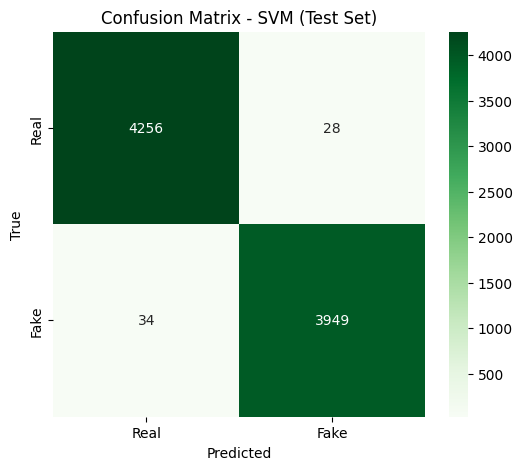

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cmat_svm_test, annot=True, fmt='d', cmap='Greens', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM (Test Set)')
plt.show()

Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Training the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_ngram, y_train)

MultinomialNB()

In [ ]:
# Predicting on Validation set
y_pred_val_nb = nb_model.predict(X_val_ngram)

In [ ]:
print('Validation Data Evaluation (Naive Bayes):\n')
print(f'Accuracy: {accuracy_score(y_val, y_pred_val_nb)}')
print('\nClassification Report:\n')
print(classification_report(y_val, y_pred_val_nb))

Validation Data Evaluation (Naive Bayes):

Accuracy: 0.9465

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3089
           1       0.94      0.95      0.95      2911

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



In [ ]:
# Confusion Matrix
cmat_nb = confusion_matrix(y_val, y_pred_val_nb)
cmat_nb

array([[2899,  190],
       [ 131, 2780]])

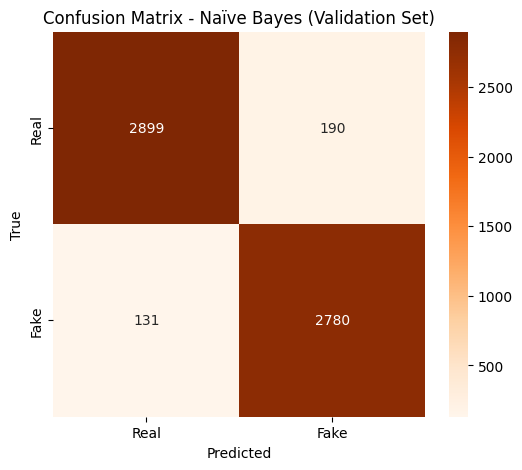

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cmat_nb, annot=True, fmt='d', cmap='Oranges', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Naïve Bayes (Validation Set)')
plt.show()

Preparing Data for LSTM

In [ ]:
#!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Maximum vocabulary size (number of unique words to consider)
VOCAB_SIZE = 10000
# How long each input will be pad/cut
MAX_SEQ_LEN = 300

In [ ]:
#Initiallising tokeniser
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(data_train['cleaned_text'])

In [ ]:
# Texts to sequences
X_train_seq = tokenizer.texts_to_sequences(data_train['cleaned_text'])
X_val_seq = tokenizer.texts_to_sequences(data_val['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(data_test['cleaned_text'])

In [ ]:
# Pad sequences to same length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

In [ ]:
y_train = data_train['label']
y_val = data_val['label']
y_test = data_test['label']

In [ ]:
# Sizes of the pad sequence datasets
print(f"Training set shape: {X_train_pad.shape}")
print(f"Validation set shape: {X_val_pad.shape}")
print(f"Test set shape: {X_test_pad.shape}")

Training set shape: (30000, 300)
Validation set shape: (6000, 300)
Test set shape: (8267, 300)


Building and Training the LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Defining the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_SEQ_LEN),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model summary
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_val_pad, y_val)
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5944 - loss: 0.6476 - val_accuracy: 0.8655 - val_loss: 0.3964
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.8441 - loss: 0.4286 - val_accuracy: 0.8738 - val_loss: 0.3760
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7584 - loss: 0.4980 - val_accuracy: 0.6222 - val_loss: 0.5902
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6983 - loss: 0.5247 - val_accuracy: 0.8205 - val_loss: 0.3918
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8276 - loss: 0.3909 - val_accuracy: 0.9530 - val_loss: 0.1532


In [ ]:
# Evaluation of LSTM on Test Set
test_loss, test_accuracy = lstm_model.evaluate(X_test_pad, y_test, verbose=2)

print("LSTM Performance: ")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

259/259 - 2s - 7ms/step - accuracy: 0.9578 - loss: 0.1431
LSTM Performance: 
Test Accuracy: 0.9578
Test Loss: 0.1431


Bidirectional LSTM

In [ ]:
from tensorflow.keras.layers import Bidirectional

# Defining the model
bilstm_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_SEQ_LEN),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Compile
bilstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Model summary
bilstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
history_bilstm = bilstm_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_val_pad, y_val)
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.8523 - loss: 0.2924 - val_accuracy: 0.9813 - val_loss: 0.0531
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9924 - loss: 0.0258 - val_accuracy: 0.9745 - val_loss: 0.0754
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9954 - loss: 0.0182 - val_accuracy: 0.9867 - val_loss: 0.0555
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9965 - loss: 0.0116 - val_accuracy: 0.9823 - val_loss: 0.0620
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 0.9852 - val_loss: 0.0643


In [ ]:
# Evaluating Bidirectional LSTM on test set
test_loss_bilstm, test_accuracy_bilstm = bilstm_model.evaluate(X_test_pad, y_test, verbose=2)

print("Bidirectional LSTM Performance: ")
print(f"Test Accuracy: {test_accuracy_bilstm:.4f}")
print(f"Test Loss: {test_loss_bilstm:.4f}")


259/259 - 3s - 13ms/step - accuracy: 0.9850 - loss: 0.0606
Bidirectional LSTM Performance: 
Test Accuracy: 0.9850
Test Loss: 0.0606


Word2Vec with LSTM

In [ ]:
# Downloading GloVe 100D
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-05-02 21:42:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-02 21:42:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-02 21:42:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Loading GloVe into a dictionary
embedding_idx = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
  for line in f:
    vals = line.split()
    word = vals[0]
    vector = np.asarray(vals[1:], dtype='float32')
    embedding_idx[word] = vector

print(f'Loaded {len(embedding_idx)} word vectors from GloVe')

Loaded 400000 word vectors from GloVe


In [ ]:
# Creating Embedding Matrix

# dimensions
EMBEDDING_DIM = 100
word_index = tokenizer.word_index
num_words = min(VOCAB_SIZE, len(word_index) + 1)

# Initialising matrix with zeros
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# Filling matrix with GloVe vectors
for word, i in word_index.items():
  if i < num_words:
    embedding_vector = embedding_idx.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [ ]:
# Building LSTM with GloVe - Frozen

lstm_glove_frozen = Sequential([
    Embedding(input_dim = num_words,
              output_dim = EMBEDDING_DIM,
              weights = [embedding_matrix],
              input_length = MAX_SEQ_LEN,
              trainable = False),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compiling the model
lstm_glove_frozen.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Training the model
history_glove = lstm_glove_frozen.fit(
    X_train_pad, y_train,
    epochs = 5,
    batch_size = 128,
    validation_data = (X_val_pad, y_val)
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7351 - loss: 0.5236 - val_accuracy: 0.5723 - val_loss: 0.6673
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7547 - loss: 0.5148 - val_accuracy: 0.7675 - val_loss: 0.4730
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7868 - loss: 0.4518 - val_accuracy: 0.5315 - val_loss: 0.6886
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5494 - loss: 0.6809 - val_accuracy: 0.8462 - val_loss: 0.4286
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8352 - loss: 0.4385 - val_accuracy: 0.7208 - val_loss: 0.5284


In [ ]:
# Evaluating on test set
test_loss_glove, test_acc_glove = lstm_glove_frozen.evaluate(X_test_pad, y_test, verbose = 2)

print("GloVe LSTM (Frozen) Performance: ")
print(f'Test Accuracy: {test_acc_glove:.4f}')
print(f'Test Loss: {test_loss_glove:.4f}')

259/259 - 2s - 7ms/step - accuracy: 0.7126 - loss: 0.5323
GloVe LSTM (Frozen) Performance: 
Test Accuracy: 0.7126
Test Loss: 0.5323


In [ ]:
# Building LSTM with GloVe - Trainable

lstm_glove_trainable = Sequential([
    Embedding(input_dim = num_words,
              output_dim = EMBEDDING_DIM,
              weights = [embedding_matrix],
              input_length = MAX_SEQ_LEN,
              trainable = True),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compiling the model
lstm_glove_trainable.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Training the model
history_glove1 = lstm_glove_trainable.fit(
    X_train_pad, y_train,
    epochs = 5,
    batch_size = 128,
    validation_data = (X_val_pad, y_val)
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6702 - loss: 0.5874 - val_accuracy: 0.6018 - val_loss: 0.6484
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6405 - loss: 0.6069 - val_accuracy: 0.9028 - val_loss: 0.3093
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5535 - loss: 0.6878 - val_accuracy: 0.5148 - val_loss: 0.6927
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5113 - loss: 0.6934 - val_accuracy: 0.5148 - val_loss: 0.6915
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5181 - loss: 0.6926 - val_accuracy: 0.5187 - val_loss: 0.6926


In [ ]:
# Evaluating on test set
test_loss_glove, test_acc_glove = lstm_glove_trainable.evaluate(X_test_pad, y_test, verbose = 2)

print("GloVe LSTM (Trainable) Performance: ")
print(f'Test Accuracy: {test_acc_glove:.4f}')
print(f'Test Loss: {test_loss_glove:.4f}')

259/259 - 1s - 6ms/step - accuracy: 0.5228 - loss: 0.6925
GloVe LSTM (Trainable) Performance: 
Test Accuracy: 0.5228
Test Loss: 0.6925


GloVe + BiLSTM

In [ ]:
# Defining Bidirectional LSTM with GloVe - Frozen
bilstm_glove_frozen = Sequential([
    Embedding(
        input_dim = num_words,
        output_dim = EMBEDDING_DIM,
        weights = [embedding_matrix],
        input_length = MAX_SEQ_LEN,
        trainable = False),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')

])

In [ ]:
# Compile
bilstm_glove_frozen.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Training the model
history_bilstm_glove = bilstm_glove_frozen.fit(
    X_train_pad, y_train,
    epochs = 5,
    batch_size = 128,
    validation_data = (X_val_pad, y_val)
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8652 - loss: 0.3189 - val_accuracy: 0.9505 - val_loss: 0.1493
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9511 - loss: 0.1388 - val_accuracy: 0.9620 - val_loss: 0.1136
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9625 - loss: 0.1094 - val_accuracy: 0.9662 - val_loss: 0.1021
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9676 - loss: 0.0907 - val_accuracy: 0.9723 - val_loss: 0.0834
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9745 - loss: 0.0726 - val_accuracy: 0.9783 - val_loss: 0.0712


In [ ]:
# Evaluate the model on test set
test_loss_bilstm_glove, test_acc_bilstm_glove = bilstm_glove_frozen.evaluate(X_test_pad, y_test, verbose = 2)

print("BiLSTM + GloVe (Frozen) Performance: ")
print(f'Test Accuracy: {test_acc_bilstm_glove:.4f}')
print(f'Test Loss: {test_loss_bilstm_glove:.4f}')


259/259 - 3s - 11ms/step - accuracy: 0.9790 - loss: 0.0637
BiLSTM + GloVe (Frozen) Performance: 
Test Accuracy: 0.9790
Test Loss: 0.0637


In [ ]:
# Defining Bidirectional LSTM with GloVe - Trainable
bilstm_glove_trainable = Sequential([
    Embedding(
        input_dim = num_words,
        output_dim = EMBEDDING_DIM,
        weights = [embedding_matrix],
        input_length = MAX_SEQ_LEN,
        trainable = True),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')

])

In [ ]:
# Compile
bilstm_glove_trainable.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Training the model
history_bilstm_glove = bilstm_glove_trainable.fit(
    X_train_pad, y_train,
    epochs = 5,
    batch_size = 128,
    validation_data = (X_val_pad, y_val)
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.8959 - loss: 0.2587 - val_accuracy: 0.9605 - val_loss: 0.1117
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.9768 - loss: 0.0716 - val_accuracy: 0.9782 - val_loss: 0.0723
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9888 - loss: 0.0378 - val_accuracy: 0.9832 - val_loss: 0.0561
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9960 - loss: 0.0154 - val_accuracy: 0.9873 - val_loss: 0.0455
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9923 - loss: 0.0221 - val_accuracy: 0.9808 - val_loss: 0.0597


In [ ]:
# Evaluate the model on test set
test_loss_bilstm_glove, test_acc_bilstm_glove = bilstm_glove_trainable.evaluate(X_test_pad, y_test, verbose = 2)

print("BiLSTM + GloVe (Trainable) Performance: ")
print(f'Test Accuracy: {test_acc_bilstm_glove:.4f}')
print(f'Test Loss: {test_loss_bilstm_glove:.4f}')


259/259 - 3s - 10ms/step - accuracy: 0.9814 - loss: 0.0548
BiLSTM + GloVe (Trainable) Performance: 
Test Accuracy: 0.9814
Test Loss: 0.0548


**Error Analysis**

In [ ]:
# Function for printing confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()


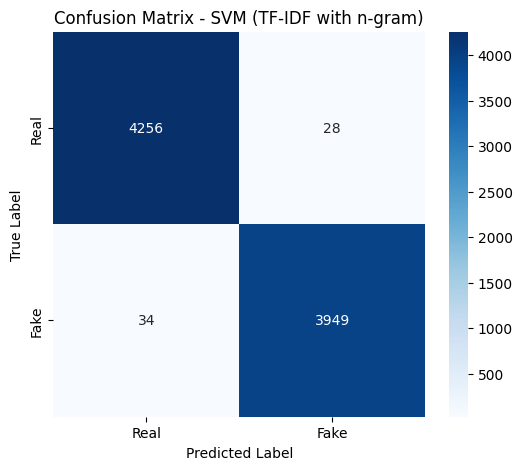

In [ ]:
# Predict with SVM
y_pred_svm = svm_model.predict(X_test_ngram)

# Plot confusion matrix
plot_conf_matrix(y_test, y_pred_svm, title="Confusion Matrix - SVM (TF-IDF with n-gram)")


259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


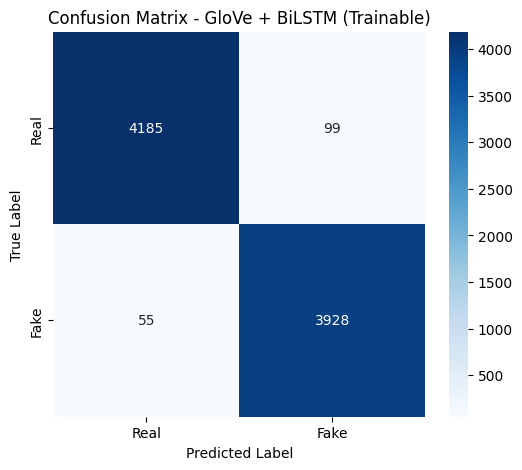

In [ ]:
# Predict with BiLSTM
y_pred_bilstm_glove = (bilstm_glove_trainable.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Plot confusion matrix
plot_conf_matrix(y_test, y_pred_bilstm_glove, title="Confusion Matrix - GloVe + BiLSTM (Trainable)")


In [ ]:
def print_misclassified_examples(y_true, y_pred, texts, max_examples=25, model_name="Model"):
    errors = (y_true != y_pred)
    misclassified_indices = [i for i, wrong in enumerate(errors) if wrong]
    print(f"=== Misclassified Examples ({model_name}) ===")
    for i in misclassified_indices[:max_examples]:
        print(f"\n--- Example #{i} ---")
        print(f"Actual Label: {y_true[i]} | Predicted Label: {y_pred[i]}")
        print(f"Text:\n{texts.iloc[i][:200]}...")  # Shortened output for readability


In [ ]:
print_misclassified_examples(y_test, y_pred_svm, data_test['text'], model_name="SVM (TF-IDF with N-Grams)")

=== Misclassified Examples (SVM (TF-IDF with N-Grams)) ===

--- Example #138 ---
Actual Label: 1 | Predicted Label: 0
Text:
The  Great Firewall of China    the world s most extensive effort to try to control cyberspace   has become more formidable under President Xi Jinping.  Authorities have closed some video and audio st...

--- Example #140 ---
Actual Label: 0 | Predicted Label: 1
Text:
Bill AukenThe day after US warships rained some 60 Tomahawk missiles on a Syrian government airbase, US officials made it clear that this unilateral and criminal attack against an oppressed former col...

--- Example #373 ---
Actual Label: 0 | Predicted Label: 1
Text:
President-elect Donald Trump is throwing a private New Year s Eve party at his Mar-a-Lago Club that is expected to draw hundreds of guests, including Sylvester Stallone.Via: Hollywood ReporterPhoto Cr...

--- Example #527 ---
Actual Label: 1 | Predicted Label: 0
Text:
A year-long audit of the program overseeing U.S. labs that handle let

In [ ]:
print_misclassified_examples(y_test, y_pred_bilstm_glove, data_test['text'], model_name="GloVe + BiLSTM (Trainable)")

=== Misclassified Examples (GloVe + BiLSTM (Trainable)) ===

--- Example #87 ---
Actual Label: 1 | Predicted Label: 0
Text:
Alan Futerfas, the lawyer Donald Trump Jr. has hired to represent him in connection with Russia-related probes, has over 25 years experience in handling government investigations and criminal cases. J...

--- Example #133 ---
Actual Label: 0 | Predicted Label: 1
Text:
Republicans in Texas, including Gov. Greg Abbott, ripped into the new $44 billion White House disaster relief aid request as  inadequate.  It s been two months since the state was devastated by Hurric...

--- Example #138 ---
Actual Label: 1 | Predicted Label: 0
Text:
The  Great Firewall of China    the world s most extensive effort to try to control cyberspace   has become more formidable under President Xi Jinping.  Authorities have closed some video and audio st...

--- Example #140 ---
Actual Label: 0 | Predicted Label: 1
Text:
Bill AukenThe day after US warships rained some 60 Tomahawk missiles 

Saving the models

In [ ]:
import joblib

joblib.dump(tfidf_ngram, '/content/drive/MyDrive/NLP_Coursework/tfidf_ngram.pkl')
joblib.dump(svm_model, '/content/drive/MyDrive/NLP_Coursework/svm_model.pkl')

['/content/drive/MyDrive/NLP_Coursework/svm_model.pkl']

In [ ]:
bilstm_glove_trainable.save('/content/drive/MyDrive/NLP_Coursework/bilstm_glove_trainable.h5')

In [ ]:
import pickle

with open('/content/drive/MyDrive/NLP_Coursework/tokenizer.pkl', 'wb') as f:
  pickle.dump(tokenizer, f)

In [ ]:
with open('/content/drive/MyDrive/NLP_Coursework/max_len.txt', 'w') as f:
  f.write(str(MAX_SEQ_LEN))